# Polygenic Risk Score

This tutorial is based on a paper called [Tutorial: a guide to performing polygenic risk score analyses](https://www.nature.com/articles/s41596-020-0353-1) with slightly modified content.
The detail information can be found [here](https://choishingwan.github.io/PRS-Tutorial/).

After the bioinformatic pipeline and after processing the data for the whole cohort or population, we get a variant call format (VCF) file that represent the whole cohort.
Now based on this data, we want to mine some information that is useful for further analysis or biological experiment.

First, we prepare all necessary path and libraries for this session.

In [8]:
from os.path import join
import numpy as np
import pandas as pd
import cyvcf2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.linear_model import LinearRegression, ElasticNet

In [9]:
ORIG_DATA = 'data'

PHENO_FNAME = 'EUR.height'
BASE_FNAME = 'Height.QC.Pval.Transformed'
VCF_FNAME = 'EUR.QC.vcf.gz'

## Quality Control

Before we fit a polygenic risk score model, the data must be quality controlled.
The quality control steps can be described as follows:

1. Standard Genome Wide Association Study (GWAS) quality control: include only SNPs with minimum minor allele frequency (MAF) greater that certain threshold.
2. Remove samples or SNPs with high rate of genotype missingness: High rate of genotype missingness indicates problems in the DNA sampling or preprocessing step.
3. Remove duplicate SNPs.
4. Remove samples for which there are difference between reported sex and that indicated by the sex chromosome.
5. Linkage Disequilibrium: Alleles on neighbouring loci might be dependent on each other due to evolutionary reason (recombination, selection, mutation and heredity).
6. Clumping: Equivalent to feature selection in machine learning.
7. P-value thresholding: Remove SNPs with low predictive power.

In this session, we provide quality controlled data. So in this step, we just load the data and merge it together.

In [10]:
! echo "Loading data..."
pheno_df = pd.read_csv(join(ORIG_DATA, PHENO_FNAME), delimiter='\t') #Load phenotype data
filtered_base_df = pd.read_csv(join(ORIG_DATA, BASE_FNAME), delimiter='\t')

vcf = cyvcf2.VCF(join(ORIG_DATA, VCF_FNAME))
gt_mat = np.empty((len(vcf.samples), len(filtered_base_df), 2))

i_var = 0 # count the number of SNPs found

for _, rec in filtered_base_df.iterrows(): # iterate over all valid SNPs
    
    # Get the chromosome and position
    chr = rec['CHR']
    pos = rec['BP']
    
    for variant in vcf(f"{chr}:{pos}-{pos}"): # query SNP per sample from the file
        
        variant_np = np.array(variant.genotype.array(), dtype=np.int8) # convert query result to numpy array
        variant_np = variant_np[:, :2] # Takes only the genotypes without phasing information
        
        gt_mat[:, i_var,  :] = variant_np # store data in our genotype matrix
        
        i_var += 1 # increase the counter
        break
    
gt_mat = gt_mat[:, :i_var, :].reshape(len(vcf.samples), -1)

vcf_samples_df = pd.DataFrame(np.array(vcf.samples), columns=['ID'])
merged_df = vcf_samples_df.merge(pheno_df, indicator=True, how='left')

sample_mask = (merged_df['_merge'] == 'both').to_numpy()
gt_mat = gt_mat[sample_mask, :]
merged_df = merged_df[sample_mask]
! echo "Data loaded!"

Loading data...
Data loaded!


## Fitting a Polygenic Risk Score Model

We prepare the dataset for supervised model training.
Two data are required: `X` and `y`.
We can now assign genotype matrix as the `X` (or the input of the model) and the phenotype as the `y` (or the ground truth)

In [11]:
X = gt_mat
y = merged_df['Height'].to_numpy()

We should split the dataset into 3 splits:

1. Training dataset (60%): The data used for training or fitting the model.
2. Validation dataset (20%): The data used to measure the performance of the fitted model and to optimize the hyperparameters.
3. Test dataset (20%): The dataset only used to measure the approximate generalization performance.

Split the dataset into (training,valid) and test.

In [12]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.2)

Because of the splitting proces, it is possible that the model and the hyperparameters of the model is good because of the data split.
Given other split, the performance of the model might drop significantly.
Thus, we try to make our model as robust as possible using [stratified k-fold](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold) for classification or shuffle split for regression.

The idea is we try to split the data into training and validation dataset multiple times, each with different split.
The model should perform well accross all possible splits.

In [13]:
! echo "Training..."
CV = 5
skf = ShuffleSplit(CV, random_state=36) # initialize split with random state for reproducability

train_perf = np.empty(CV)
valid_perf = np.empty(CV)
models = np.empty(CV, dtype=object)
for i_split, (train_idx, valid_idx) in enumerate(skf.split(X_train_valid, y_train_valid)):
    print("Split {}...".format(i_split))
    X_train = X_train_valid[train_idx, :]
    y_train = y_train_valid[train_idx]
    
    X_valid = X_train_valid[valid_idx, :]
    y_valid = y_train_valid[valid_idx]
    
    m = LinearRegression()
    models[i_split] = m
    m.fit(X_train, y_train)
    
    train_perf[i_split] = (((m.predict(X_train)-y_train)) ** 2).mean() # Compute MSE of the training split
    valid_perf[i_split] = (((m.predict(X_valid)-y_valid)) ** 2).mean() # Compute MSE of the validation split
! echo "Training finished!"

Training...
Split 0...
Split 1...
Split 2...
Split 3...
Split 4...
Training finished!


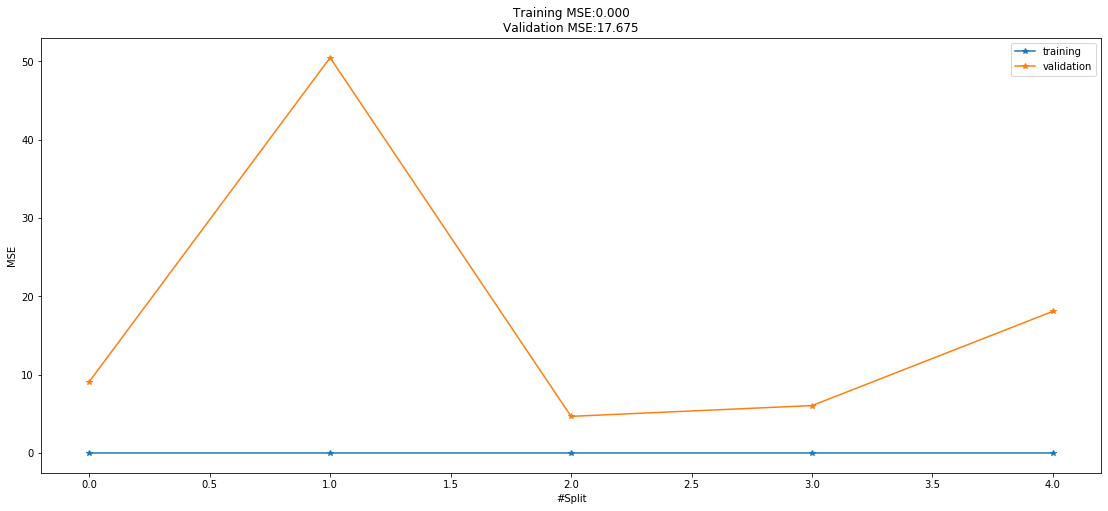

In [14]:
plt.figure(figsize=(19, 8))
plt.plot(train_perf, '-*', label='training')
plt.plot(valid_perf, '-*', label='validation')
plt.title(
    "Training MSE:{:.03f}".format(train_perf.mean()) + '\n' +
    "Validation MSE:{:.03f}".format(valid_perf.mean())
)
plt.xlabel('#Split')
plt.ylabel('MSE')
plt.legend()

As we can see, the model is overfit.

Now, lets try to regularize the model using [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)) and [Ridge](https://en.wikipedia.org/wiki/Ridge_regression) to reduce the overfit and at the same time improve the performance.

In [15]:
! echo "Training..."
CV = 5
skf = ShuffleSplit(CV, random_state=42) # initialize split with random state for reproducability

train_perf = np.empty(CV)
valid_perf = np.empty(CV)
for i_split, (train_idx, valid_idx) in enumerate(skf.split(X_train_valid, y_train_valid)):
    print("Split {}...".format(i_split))
    X_train = X_train_valid[train_idx, :]
    y_train = y_train_valid[train_idx]
    
    X_valid = X_train_valid[valid_idx, :]
    y_valid = y_train_valid[valid_idx]
    
    m = ElasticNet(alpha=.8, l1_ratio=0.1)
    m.fit(X_train, y_train) # we use ElasticNet: combination of linear regression with regularization methods Ridge and Lasso
    
    train_perf[i_split] = (((m.predict(X_train)-y_train)) ** 2).mean() # Compute MSE of the training split
    valid_perf[i_split] = (((m.predict(X_valid)-y_valid)) ** 2).mean() # Compute MSE of the validation split
! echo "Training finished!"

Training...
Split 0...
Split 1...
Split 2...
Split 3...
Split 4...
Training finished!


Plot the features (SNPs) importance to show which SNPs influence the polygenic risk score

Text(0, 0.5, 'Importance (magnitude of the weights)')

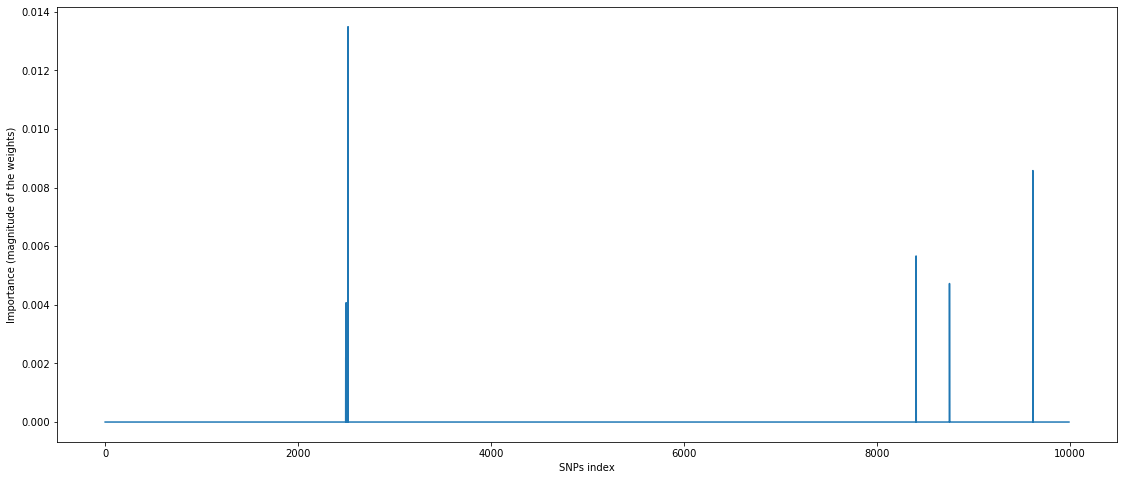

In [16]:
plt.figure(figsize=(19, 8))
plt.plot(np.abs(m.coef_))
plt.xlabel('SNPs index')
plt.ylabel('Importance (magnitude of the weights)')

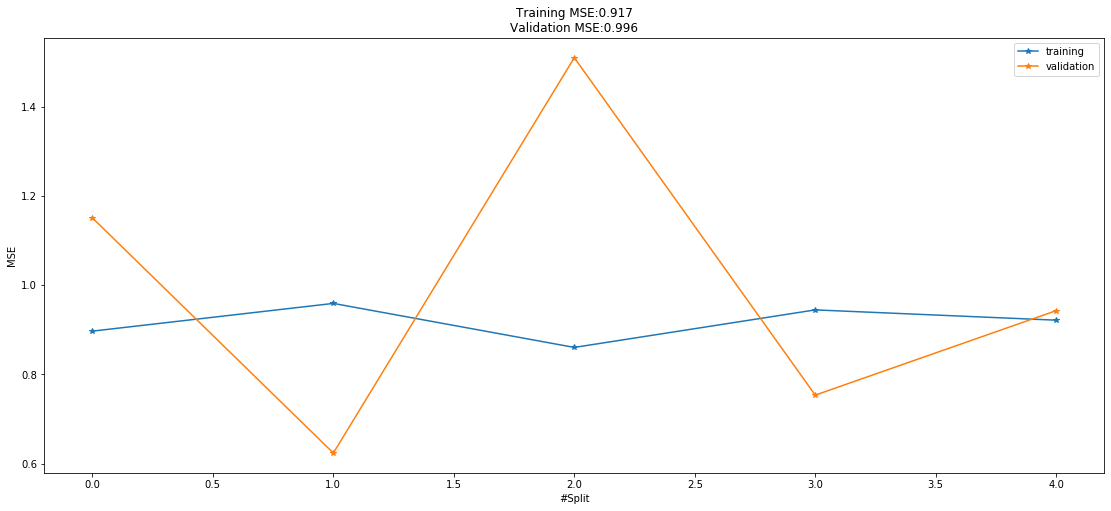

In [17]:
plt.figure(figsize=(19, 8))
plt.plot(train_perf, '-*', label='training')
plt.plot(valid_perf, '-*', label='validation')
plt.title(
    "Training MSE:{:.03f}".format(train_perf.mean()) + '\n' +
    "Validation MSE:{:.03f}".format(valid_perf.mean())
)
plt.xlabel('#Split')
plt.ylabel('MSE')
plt.legend()

Now we see that the performance gap difference between training and validation is smaller and at the same time we improve the overall performance.
The model and the polygenic risk score can be further optimized to improve the performance or to reduce the overfit.
Based on the model prediction and the SNPs importance, we can experiment in wet lab based on the result or the result can serve as insight for doctors or bioinformaticians.